# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import scrnatools as rna
import numpy as np
import pandas as pd
import pickle

In [3]:
# Setup figure params
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Helvetica"
sc.set_figure_params(dpi=80, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
plt.rcParams['axes.unicode_minus'] = False
cmap = sns.color_palette("colorblind")

In [4]:
warnings.resetwarnings()

# Import data

In [5]:
processedDataPath = "/mnt/iacchus/joe/processed_data/"

In [6]:
aire = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/pairwise_processing/aire_TECs.h5ad")
fezf2 = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/pairwise_processing/fezf2_TECs.h5ad")
scores = pd.read_csv("../../analysis/entropy/cell_x_gene_atlas_cell_type_entropy.csv", index_col=0)
scores = scores[scores.index.isin(aire.var_names)].copy()
aire = aire[:, aire.var_names.isin(scores.index)].copy()
fezf2 = fezf2[:, fezf2.var_names.isin(scores.index)].copy()

# TRA fraction (Aire)

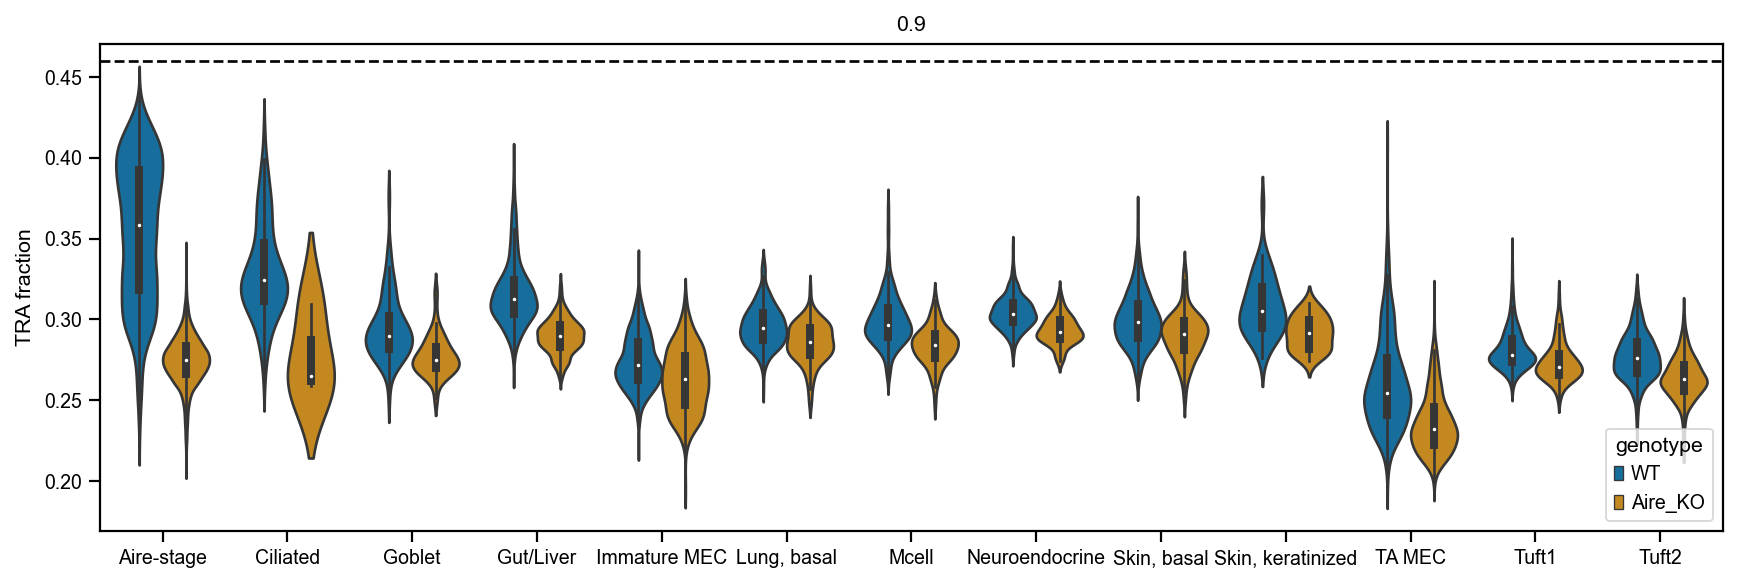

In [7]:
for tau_threshold in [0.9]:
    TRAs = scores[scores[f"tau_TRA_{tau_threshold}"] | scores[f"entropy_TRA_{tau_threshold}"]].index
    nonTRAs = scores[~scores.index.isin(TRAs)].index
    
    exprs = rna.tl.get_expression_matrix(aire, gene_data="scVI_normalized")
    exprs = exprs >= 0.1

    aire.obs[f"TRA_fraction_{tau_threshold}"] = exprs[TRAs].sum(axis=1)/exprs.sum(axis=1)
    aire.obs[f"TRA_number_{tau_threshold}"] = exprs[TRAs].sum(axis=1)

    plt.figure(figsize=(13,4))
    sns.violinplot(
        aire.obs,
        x="majority_voting",
        y=f"TRA_fraction_{tau_threshold}",
        hue="genotype",
        scale="width",
        width=0.75,
        hue_order=["WT", "Aire_KO"],
        palette=cmap[0:2],
    )
    plt.axhline(y=len(TRAs)/aire.shape[1], color="black", linestyle="--")
    plt.xlabel("")
    plt.ylabel("TRA fraction")
    plt.title(tau_threshold)
    plt.show()

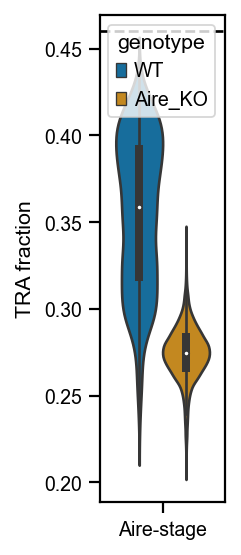

In [8]:
plt.figure(figsize=(1,4))
TRAs = scores[scores[f"tau_TRA_0.9"] | scores[f"entropy_TRA_0.9"]].index
sns.violinplot(
    aire[aire.obs.majority_voting == "Aire-stage"].obs,
    x="majority_voting",
    y=f"TRA_fraction_0.9",
    hue="genotype",
    scale="width",
    width=0.75,
    hue_order=["WT", "Aire_KO"],
    palette=cmap[0:2],
)
plt.axhline(y=len(TRAs)/aire.shape[1], color="black", linestyle="--")
plt.xlabel("")
plt.ylabel("TRA fraction")
plt.savefig(f"../../analysis/paper_figures/S3/S3H_aire_TRA_fraction.pdf")
plt.show()

# TRA fraction (Fezf2)

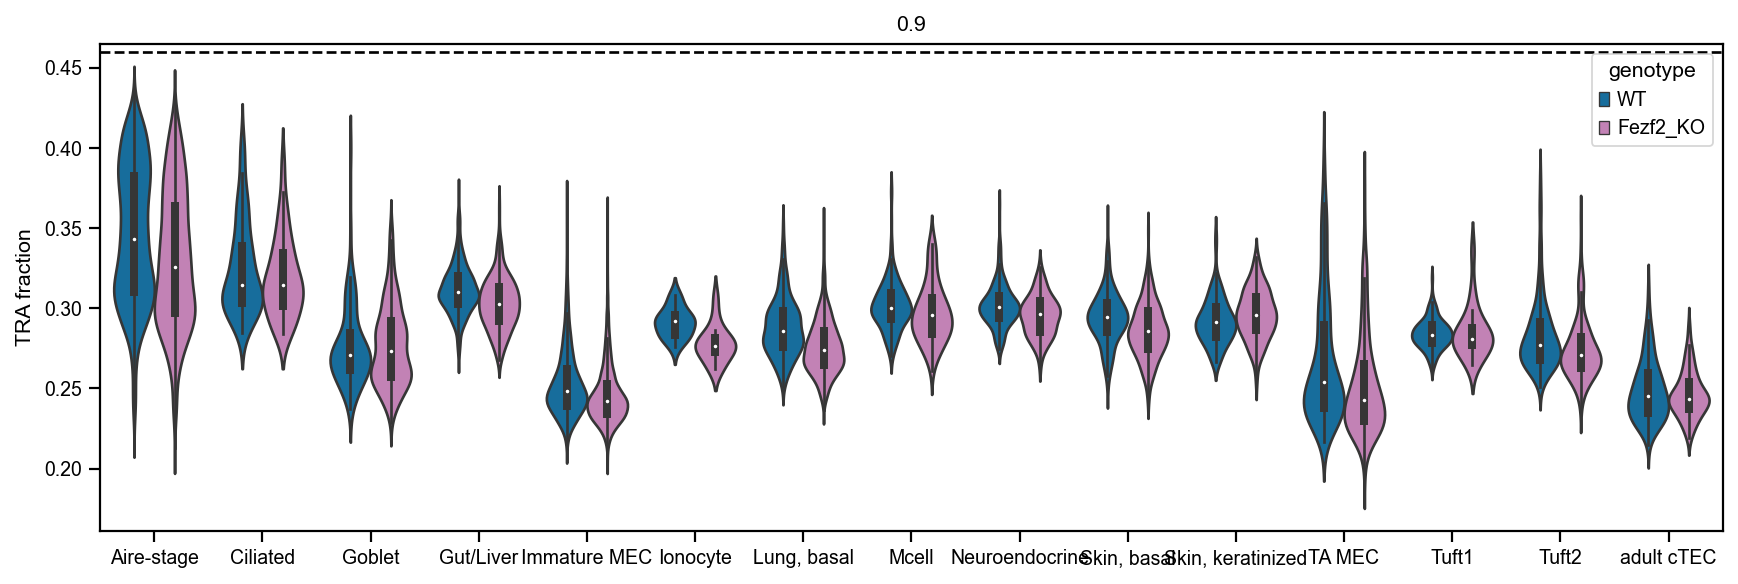

In [9]:
for tau_threshold in [0.9]:
    TRAs = scores[scores[f"tau_TRA_{tau_threshold}"] | scores[f"entropy_TRA_{tau_threshold}"]].index
    nonTRAs = scores[~scores.index.isin(TRAs)].index
    
    exprs = rna.tl.get_expression_matrix(fezf2, gene_data="scVI_normalized")
    exprs = exprs >= 0.1

    fezf2.obs[f"TRA_fraction_{tau_threshold}"] = exprs[TRAs].sum(axis=1)/exprs.sum(axis=1)
    fezf2.obs[f"TRA_number_{tau_threshold}"] = exprs[TRAs].sum(axis=1)

    plt.figure(figsize=(13,4))
    sns.violinplot(
        fezf2.obs,
        x="majority_voting",
        y=f"TRA_fraction_{tau_threshold}",
        hue="genotype",
        scale="width",
        width=0.75,
        hue_order=["WT", "Fezf2_KO"],
        palette=[cmap[0], cmap[4]],
    )
    plt.axhline(y=len(TRAs)/fezf2.shape[1], color="black", linestyle="--")
    plt.xlabel("")
    plt.ylabel("TRA fraction")
    plt.title(tau_threshold)
    plt.show()

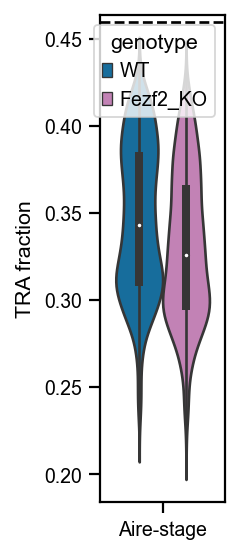

In [10]:
plt.figure(figsize=(1,4))
TRAs = scores[scores[f"tau_TRA_0.9"] | scores[f"entropy_TRA_0.9"]].index
sns.violinplot(
    fezf2[fezf2.obs.majority_voting == "Aire-stage"].obs,
    x="majority_voting",
    y=f"TRA_fraction_0.9",
    hue="genotype",
    scale="width",
    width=0.75,
    hue_order=["WT", "Fezf2_KO"],
    palette=[cmap[0], cmap[4]],
)
plt.axhline(y=len(TRAs)/fezf2.shape[1], color="black", linestyle="--")
plt.xlabel("")
plt.ylabel("TRA fraction")
plt.savefig(f"../../analysis/paper_figures/S3/S3H_fezf2_TRA_fraction.pdf")
plt.show()

# DE genes

In [11]:
with open("../../analysis/DE/pairwise_filtered_genes.pkl", 'rb') as handle:
    filtered_genes = pickle.load(handle)

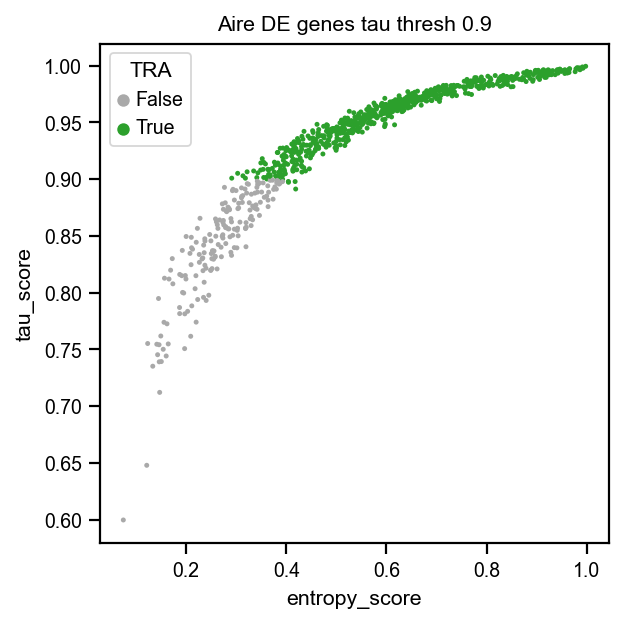

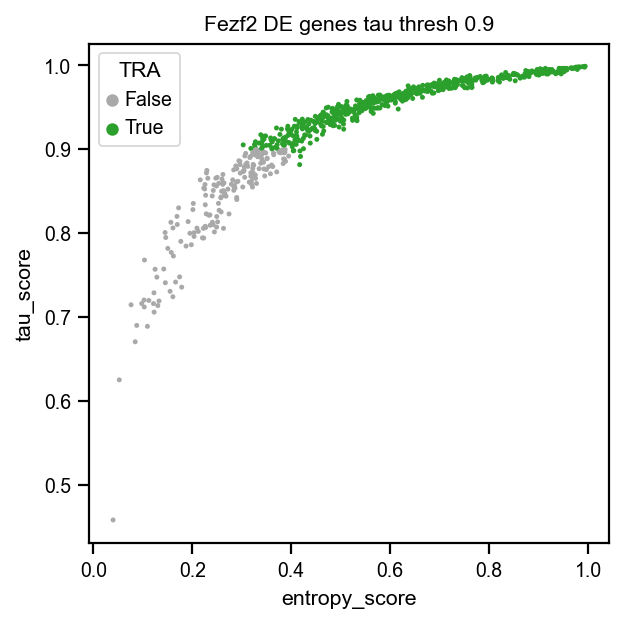

In [15]:
for tau_threshold in [0.9]:
    TRAs = scores[scores[f"tau_TRA_{tau_threshold}"] | scores[f"entropy_TRA_{tau_threshold}"]].index
    nonTRAs = scores[~scores.index.isin(TRAs)].index
    
    for genotype in ["Aire", "Fezf2"]:
        filtered = filtered_genes[f"{genotype}_max_LFC"]
        filtered["tau_score"] = scores.tau_score
        filtered["entropy_score"] = scores.entropy_score
        filtered["TRA"] = filtered.index.isin(TRAs)

        fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(4,4))
        sns.scatterplot(
            filtered,
            x="entropy_score",
            y="tau_score",
            hue="TRA",
            palette=["darkgrey", "tab:green"],
            s=5,
            linewidth=0,
        )

        plt.title(f"{genotype} DE genes tau thresh {tau_threshold}")
        plt.tight_layout()
        plt.savefig(f"../../analysis/paper_figures/S4/S4F_{genotype}_DE_genes_{tau_threshold}_TRAs.pdf")
        plt.show()